In [ ]:
#Conection with GoogleDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#CBIS DDSM Database

In [ ]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

^C
[CBIS_DDSM.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of CBIS_DDSM.zip or
        CBIS_DDSM.zip.zip, and cannot find CBIS_DDSM.zip.ZIP, period.


# Librarys

In [ ]:
%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import pandas as pd

#Functions

In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Load data and process

In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


4 8 12 6


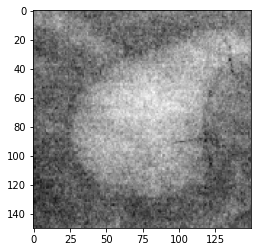

Label: [1. 0. 0. 0.]


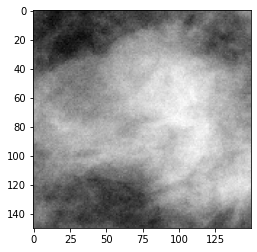

Label: [1. 0. 0. 0.]


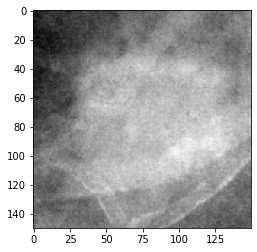

Label: [0. 1. 0. 0.]


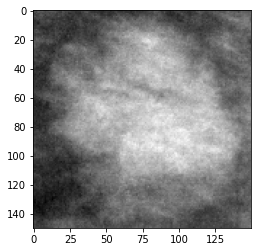

Label: [0. 1. 0. 0.]


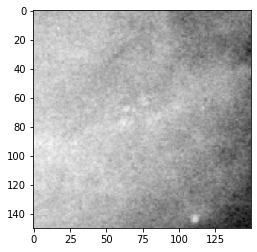

Label: [0. 0. 1. 0.]


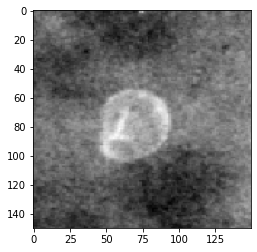

Label: [0. 0. 1. 0.]


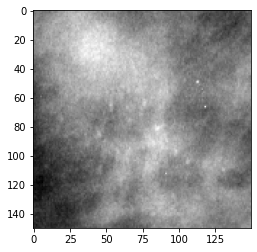

Label: [0. 0. 0. 1.]


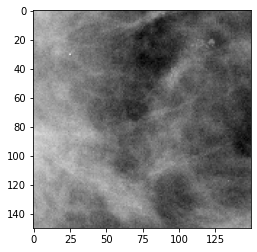

Label: [0. 0. 0. 1.]


In [ ]:
# Check images from the dataset and its label
mass_benign_index=[]
mass_malignant_index=[]
calc_benign_index=[]
calc_malignant_index=[]
for i in range(30):
  if (int(train_labels[i][0]) == 1.0):
    mass_benign_index.append(i)
  if (int(train_labels[i][1]) == 1.0):
    mass_malignant_index.append(i)
  if (int(train_labels[i][2]) == 1.0):
    calc_benign_index.append(i)
  if (int(train_labels[i][3]) == 1.0):
    calc_malignant_index.append(i)
print(len(mass_benign_index),len(mass_malignant_index), len(calc_benign_index), len(calc_malignant_index))

plt.imshow(train_images[mass_benign_index[0]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_benign_index[0]]))
plt.imshow(train_images[mass_benign_index[1]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_benign_index[1]]))


plt.imshow(train_images[mass_malignant_index[0]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_malignant_index[0]]))
plt.imshow(train_images[mass_malignant_index[1]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_malignant_index[1]]))


plt.imshow(train_images[calc_benign_index[0]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_benign_index[0]]))
plt.imshow(train_images[calc_benign_index[1]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_benign_index[1]]))

plt.imshow(train_images[calc_malignant_index[0]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_malignant_index[0]]))
plt.imshow(train_images[calc_malignant_index[1]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_malignant_index[1]]))


#Model 1
* Dense(4, activation='softmax')
* Loss function --> categorical crossentropy (more than 2 classes)

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(48, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(4, activation='softmax'))

model_1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________

#Compile, Train, Save 1

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_1.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_1 = model_1.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_1, 'model_1_4cl_end.h5')
!cp model* "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/"

Epoch 1/500
 5/16 [========>.....................] - ETA: 15s - loss: 1.3717 - acc: 0.3701
Epoch 00001: val_loss improved from inf to 1.37168, saving model to model_1_4cl_best.h5
16/16 [==============================] - 97s 6s/step - loss: 1.4547 - acc: 0.3035 - val_loss: 1.3717 - val_acc: 0.3701
Epoch 2/500
 5/16 [========>.....................] - ETA: 16s - loss: 1.3696 - acc: 0.3701
Epoch 00002: val_loss improved from 1.37168 to 1.36960, saving model to model_1_4cl_best.h5
16/16 [==============================] - 97s 6s/step - loss: 1.3765 - acc: 0.3398 - val_loss: 1.3696 - val_acc: 0.3701
Epoch 3/500
 5/16 [========>.....................] - ETA: 16s - loss: 1.3422 - acc: 0.3701
Epoch 00003: val_loss improved from 1.36960 to 1.34224, saving model to model_1_4cl_best.h5
16/16 [==============================] - 96s 6s/step - loss: 1.3716 - acc: 0.3443 - val_loss: 1.3422 - val_acc: 0.3701
Epoch 4/500
 5/16 [========>.....................] - ETA: 16s - loss: 1.3434 - acc: 0.3701
Epoch 0

#Results 1

In [ ]:
# History of accuracy and loss
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['acc']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_acc']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('model_1_4cl_best.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)
opt_pred_1 = opt_model_1.predict([test_images, test_labels])
pred_classes_1 = np.rint(opt_pred_1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model 1

Epoch [end]: 290
Epoch [opt]: 210
Valid accuracy [end]: 0.5963
Valid accuracy [opt]: 0.5963
Test accuracy [end]:  0.5923
Test accuracy [opt]:  0.6012
Valid loss [end]: 0.8141
Valid loss [opt]: 0.7968
Test loss [end]:  0.9542
Test loss [opt]:  0.9789
              precision    recall  f1-score   support

           0     0.7231    0.4159    0.5281       113
           1     0.4878    0.3030    0.3738        66
           2     0.7875    0.5943    0.6774       106
           3     0.5385    0.4118    0.4667        51

   micro avg     0.6711    0.4494    0.5383       336
   macro avg     0.6342    0.4313    0.5115       336
weighted avg     0.6692    0.4494    0.5356       336
 samples avg     0.4494    0.4494    0.4494       336



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Accuracy, Loss Graphic 1

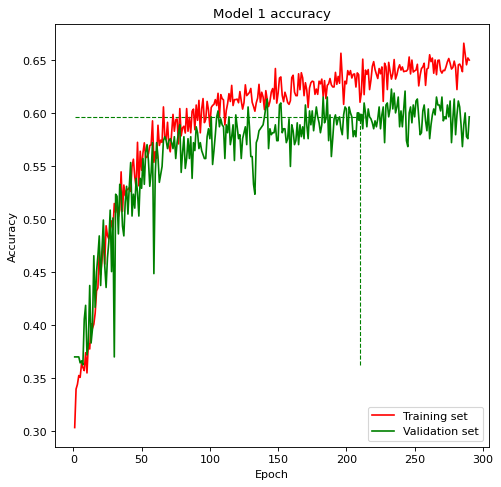

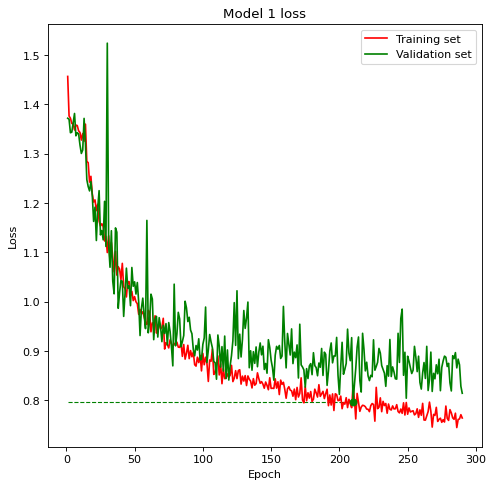

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#Classification 1

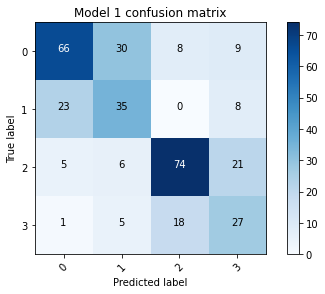

In [ ]:
pred_1_classes = opt_model_1.predict_classes(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_1_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 1 confusion matrix')